Files already downloaded and verified


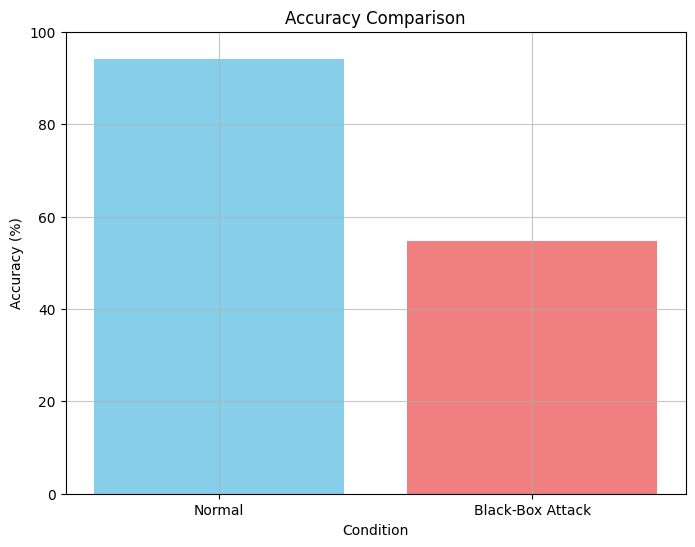

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

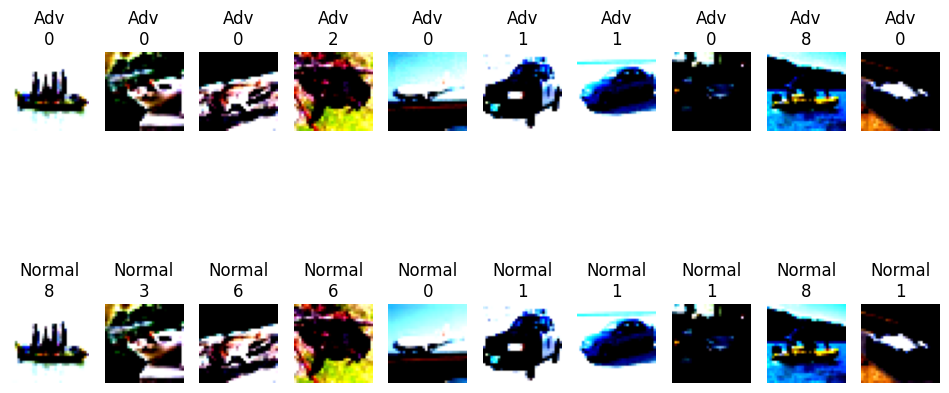

正常准确率: 94.02%
黑盒攻击后准确率: 54.74%
黑盒攻击成功率（迁移攻击）: 45.26%


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pytorchcv.model_provider import get_model as ptcv_get_model
import matplotlib.pyplot as plt

# 设置运行设备，优先使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的ResNet-20模型作为目标模型
target_model = ptcv_get_model("resnet20_cifar10", pretrained=True)
target_model = target_model.to(device)
target_model.eval()  # 设置为目标模型评估模式

# 定义代理模型LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 输入3通道，输出6通道，卷积核5x5
        self.pool = nn.MaxPool2d(2, 2)   # 最大池化层，窗口大小2x2，步长2
        self.conv2 = nn.Conv2d(6, 16, 5) # 第二层卷积，输入6通道，输出16通道
        self.fc1 = nn.Linear(16*5*5, 120)# 全连接层，输入16*5*5，输出120
        self.fc2 = nn.Linear(120, 84)    # 全连接层，输入120，输出84
        self.fc3 = nn.Linear(84, 10)     # 输出层，输入84，输出10（CIFAR-10类别数）

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 第一层卷积+ReLU+池化
        x = self.pool(F.relu(self.conv2(x)))  # 第二层卷积+ReLU+池化
        x = x.view(-1, 16*5*5)                # 展平张量
        x = F.relu(self.fc1(x))               # 全连接层+ReLU
        x = F.relu(self.fc2(x))               # 全连接层+ReLU
        x = self.fc3(x)                       # 输出层
        return x

# 初始化代理模型并设置优化器
surrogate = LeNet().to(device)
optimizer = optim.Adam(surrogate.parameters(), lr=0.001)  # 使用Adam优化器
loss_fn = nn.CrossEntropyLoss()  # 定义交叉熵损失函数

# 定义CIFAR-10测试集的数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换图像为Tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # 标准化
])
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# 训练代理模型
surrogate.train()
for epoch in range(10):  # 训练10个epoch
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # 清空梯度
        outputs = surrogate(images)  # 前向传播
        loss = loss_fn(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数

# 定义FGSM攻击函数
def fgsm_attack(model, images, labels, eps=8/255):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True  # 启用梯度计算
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()
    adv_images = images + eps * images.grad.sign()  # 生成对抗样本
    adv_images = torch.clamp(adv_images, 0, 1)  # 确保图像像素在[0,1]范围内
    return adv_images

# 计算目标模型在正常情况下的准确率
correct_normal = 0
total_normal = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = target_model(images)
        _, predicted = outputs.max(1)
        total_normal += labels.size(0)
        correct_normal += (predicted == labels).sum().item()

accuracy_normal = 100 * correct_normal / total_normal

# 评估黑盒攻击效果
correct_bb = 0
total_bb = 0
target_model.eval()
surrogate.eval()
for images, labels in testloader:
    adv_images = fgsm_attack(surrogate, images, labels)  # 使用代理模型生成对抗样本
    with torch.no_grad():
        outputs = target_model(adv_images.to(device))  # 使用目标模型评估对抗样本
        _, predicted = outputs.max(1)
        total_bb += labels.size(0)
        correct_bb += (predicted.cpu() == labels).sum().item()

accuracy_bb = 100 * correct_bb / total_bb

# 绘制准确率对比图
labels_acc = ['Normal', 'Black-Box Attack']
accuracies = [accuracy_normal, accuracy_bb]
plt.figure(figsize=(8, 6))
plt.bar(labels_acc, accuracies, color=['skyblue', 'lightcoral'])
plt.xlabel('Condition')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.ylim(0, 100)
plt.grid(True, alpha=0.7)
plt.show()

# 绘制对抗样本示例
plt.figure(figsize=(12, 6))
for i in range(10):
    # 绘制对抗样本
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(adv_images[i].cpu().detach().permute(1, 2, 0).numpy())
    plt.title(f"Adv\n{predicted[i].item()}")
    plt.axis('off')

    # 绘制原始样本
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
    plt.title(f"Normal\n{labels[i].item()}")
    plt.axis('off')

plt.show()

# 输出结果
print(f"正常准确率: {accuracy_normal:.2f}%")
print(f"黑盒攻击后准确率: {accuracy_bb:.2f}%")
print(f"黑盒攻击成功率（迁移攻击）: {100 * (1 - correct_bb / total_bb):.2f}%")